In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings

We load in the ensemble members and regrid them to a 1x1 grid. Note, these next two cells will take a long time as they are loading in all the salt fields and then regridding them. Instead we can unpickle the fields that are already regridded if we want (3rd cell after this comment).

In [3]:
#load in one ensemble member and use it to make a regridder object
f='/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.SALT.192001-200512.nc'
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
lat = xr.open_dataset(f)['TLAT']
lon = xr.open_dataset(f)['TLONG']
time=xr.open_dataset(f)['time']
depth=xr.open_dataset(f)['z_t']
salt2=xr.open_dataset(f)['SALT']

ds_out = xe.util.grid_global(1, 1)
salt2 = salt2.rename({"TLAT": "lat", "TLONG": "lon"})
salt2=salt2.drop("ULAT")
salt2=salt2.drop("ULONG")
regridder_forcesm = xe.Regridder(salt2[:,0,:,:], ds_out, "bilinear",periodic=True) #this is now the regridder object that can be applied to any of the original CESM fields
regrid_cesm = regridder_forcesm(salt2[:,0,:,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [ ]:
#Preferably skip this cell and just load in the pickled regridded objects!!

#list of salinity field for all ensemble members (pre 2005, historical runs)
salt=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.00%d.pop.h.SALT.192001-200512.nc" % i
    else:
        f="/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.0%d.pop.h.SALT.192001-200512.nc" % i
    s=xr.open_dataset(f)['SALT']
    salt.append(s[:,0,:,:])
    
#regrid salt field for all ensemble members
regridded_salt=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(salt[i])
    regridded_salt.append(s)
    
#salinity field for all ensemble members (2005 onwards)
salt_2005on=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.00%d.pop.h.SALT.200601-208012.nc" % i
    elif i<34:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.SALT.200601-208012.nc" % i
    else:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.SALT.200601-210012.nc" % i
    s=xr.open_dataset(f)['SALT']
    salt_2005on.append(s[:,0,:,:])
    
#regid salt field
regridded_salt_2005on=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(salt_2005on[i])
    regridded_salt_2005on.append(s)
    print(i)


temp=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.B20TRC5CNBDRD.f09_g16.00%d.pop.h.TEMP.192001-200512.nc" % i
    else:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.B20TRC5CNBDRD.f09_g16.0%d.pop.h.TEMP.192001-200512.nc" % i
    s=xr.open_dataset(f)['TEMP']
    temp.append(s[:,0,:,:])

#take mean of the salt members
temp_2005on=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.00%d.pop.h.TEMP.200601-208012.nc" % i
    elif i<34:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.TEMP.200601-208012.nc" % i
    else:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.TEMP.200601-210012.nc" % i
    s=xr.open_dataset(f)['TEMP']
    temp_2005on.append(s[:,0,:,:])
    
regridded_temp=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(temp[i])
    regridded_temp.append(s)
    print(i)
    

regridded_temp_2005on=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(temp_2005on[i])
    regridded_temp_2005on.append(s)
    print(i)

In [4]:
import pickle

with open("/scratch/abf376/regridded_salt_2006to2080_rcp8.5", "rb") as fp:   # Unpickling regridded salt 2006 to 2080
    regridded_salt_2005on= pickle.load(fp)
    
with open("/scratch/abf376/regridded_temp_2006to2080_rcp8.5", "rb") as fp:   # Unpickling regridded temperature 2006 to 2080
    regridded_temp_2005on= pickle.load(fp)

Instead of cutting to 1970 to 2025, let's cut 2005 to 2055

In [14]:
salt_avg_2005on=sum(regridded_salt_2005on)/34
salt_avg_2005on=salt_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_avg_2005on=salt_avg_2005on.assign_coords(latitude=salt_avg_2005on.lat[:,0],longitude=salt_avg_2005on.lon[0,:])

salt_avg_2006to2055=salt_avg_2005on[0:12*50,:,:]

In [16]:
temp_avg_2005on=sum(regridded_temp_2005on)/34
temp_avg_2005on=temp_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
temp_avg_2005on=temp_avg_2005on.assign_coords(latitude=temp_avg_2005on.lat[:,0],longitude=temp_avg_2005on.lon[0,:])

temp_avg_2006to2055=temp_avg_2005on[0:12*50,:,:]

Create area grid 

In [17]:
import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')
from area_grid import *

area=area_grid(latitudes=np.array(salt_avg_2006to2055[0,:,:].latitude),longitudes=salt_avg_2006to2055[0,:,:].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_avg_2006to2055[0,:,:].latitude,salt_avg_2006to2055[0,:,:].longitude])

Cluster the surface salinity based on 2011 to 2016

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0
(100000, 6)


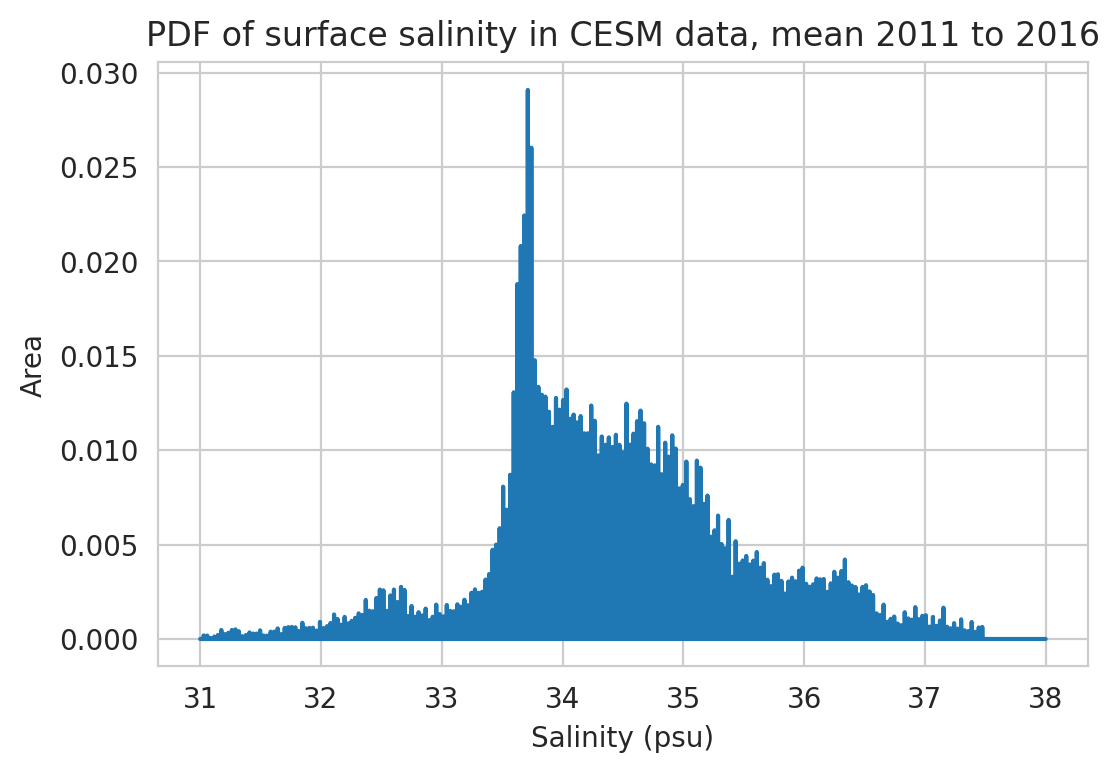

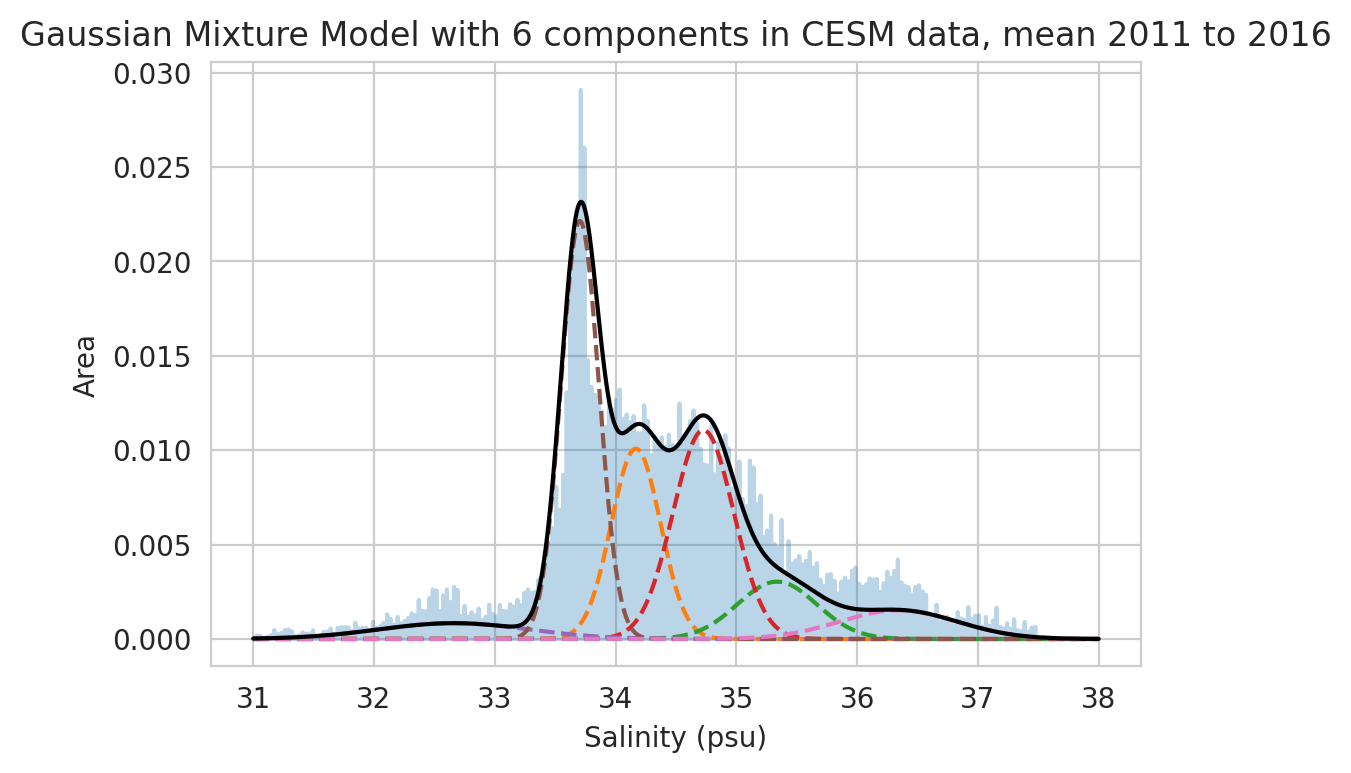

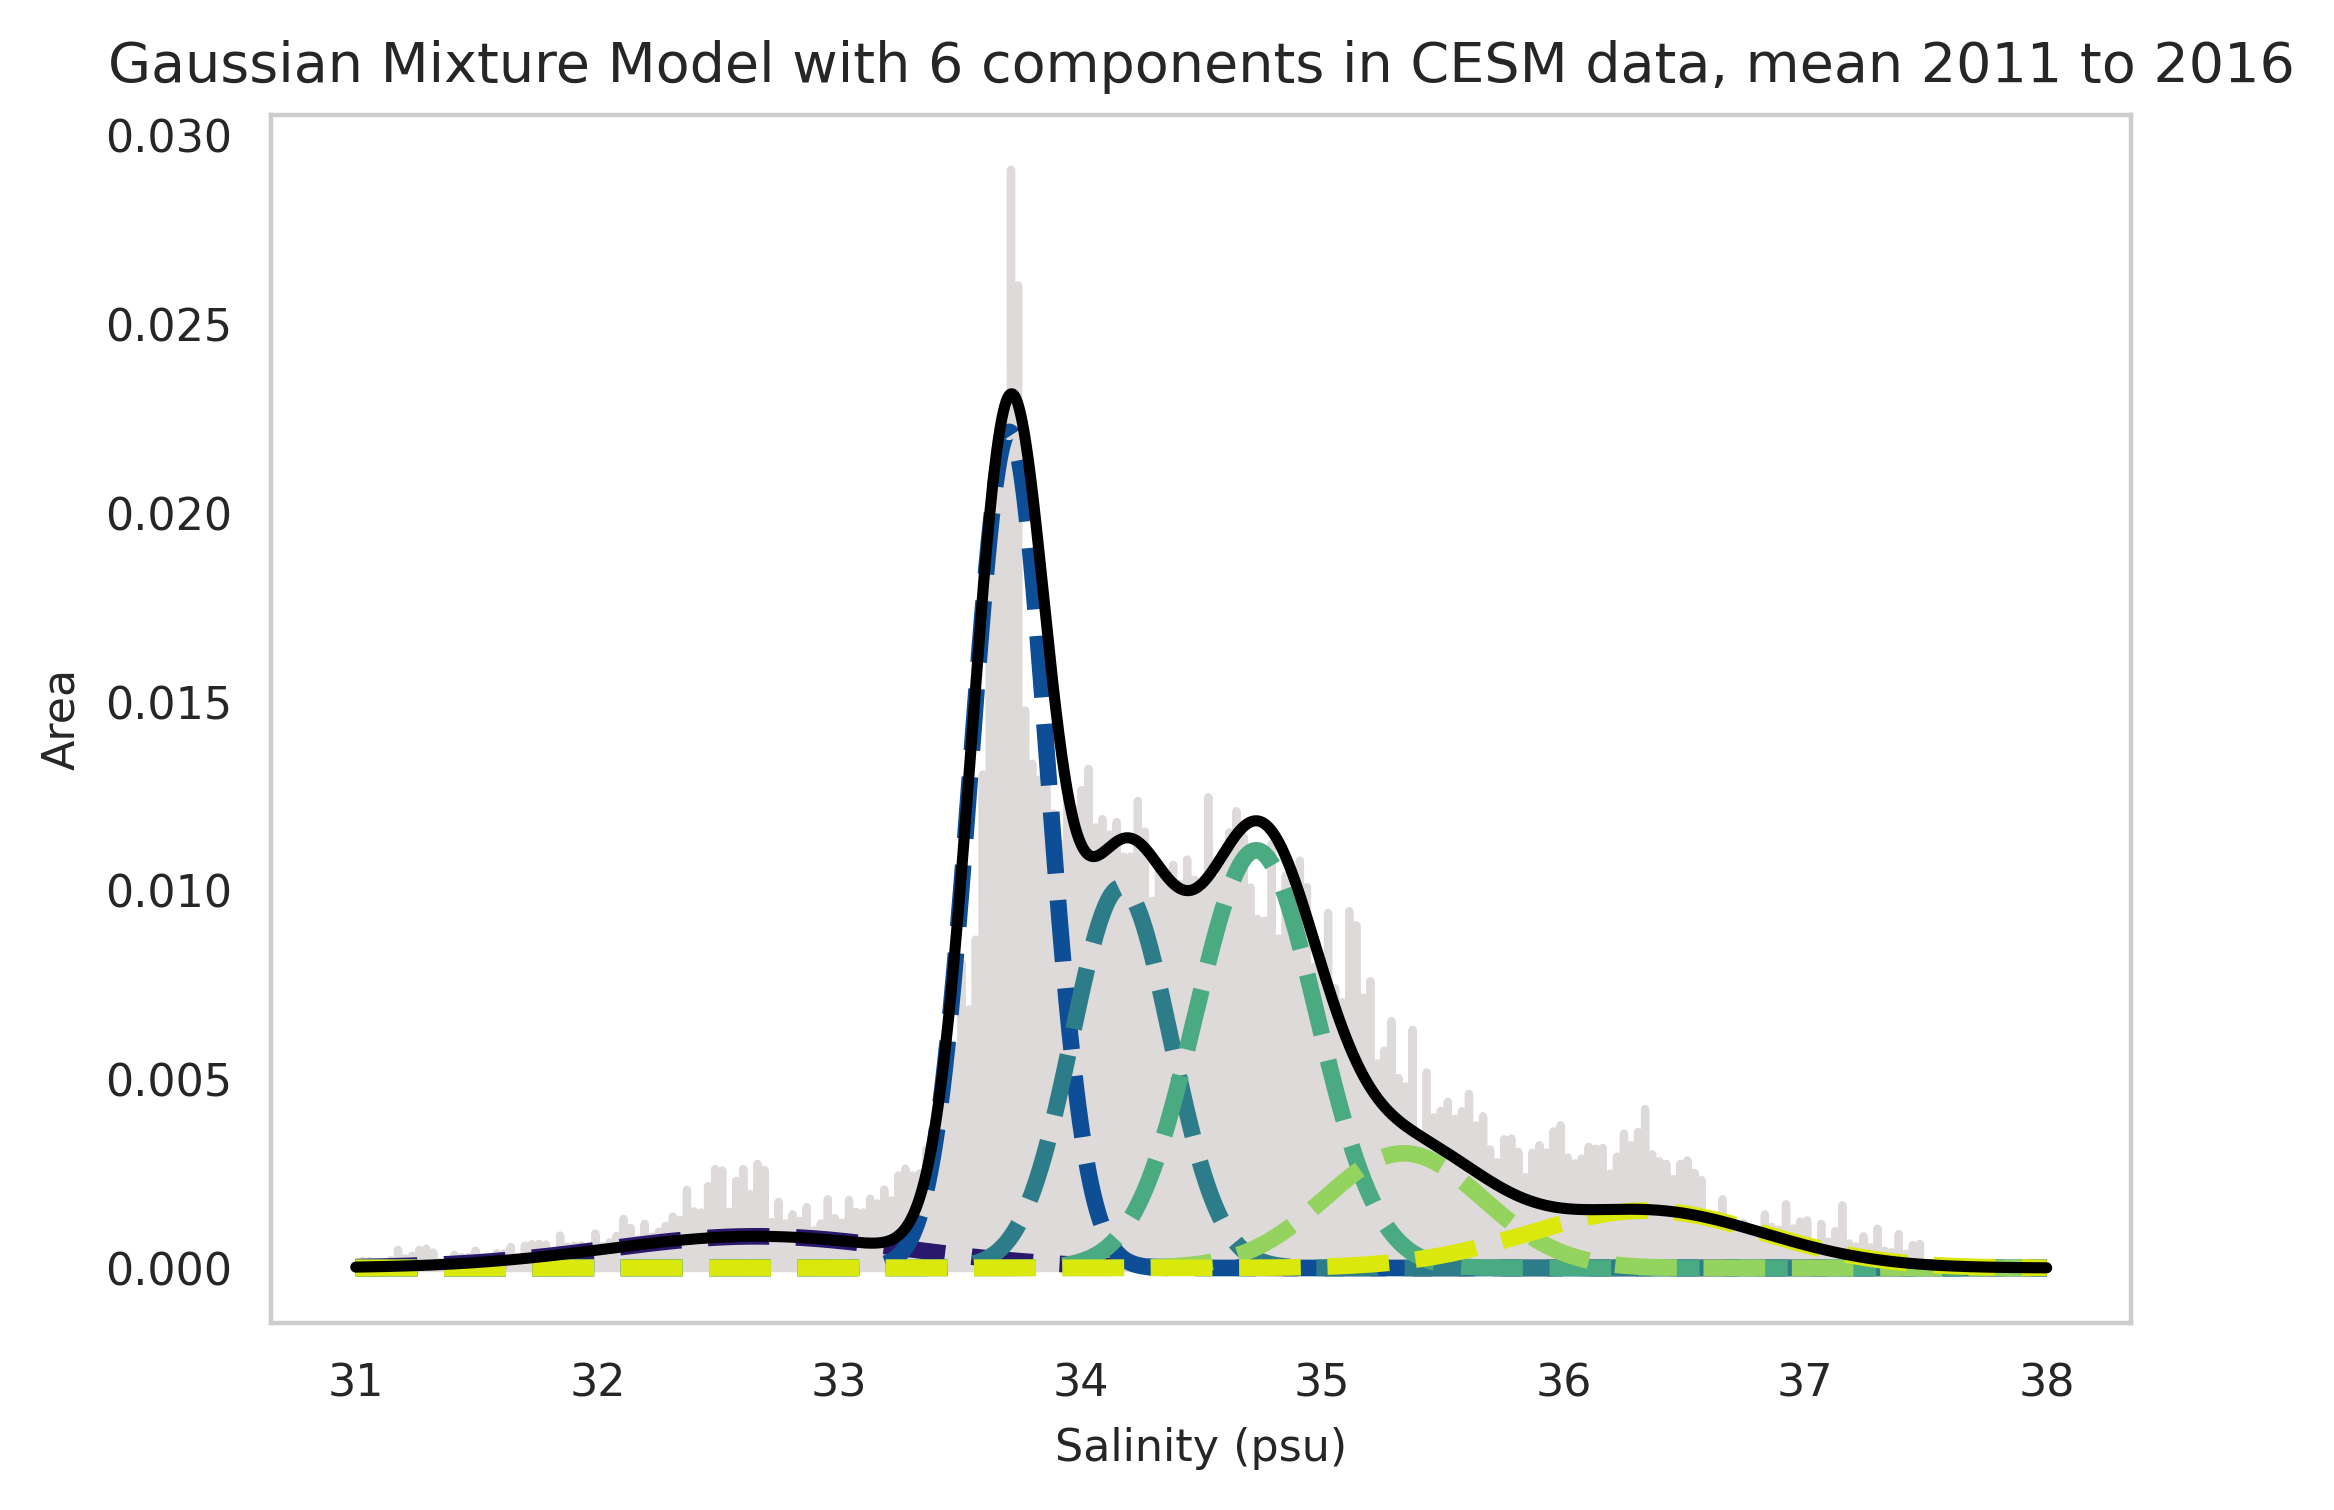

In [18]:
import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools') #make this the directory where the tools folder lives for you


n=6
%load_ext autoreload 
%autoreload 2

import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

from clustering_tools import *
mean_had_con,sigma_had_con,weights_had_con,gm=GMM_timedep((salt_avg_2006to2055[5*12:10*12,:,:].mean('time')).where(salt_avg_2006to2055[0,:,:].latitude<65),n,'CESM data, mean 2011 to 2016',precise=0,matching_paper=1) #take mean over first year

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


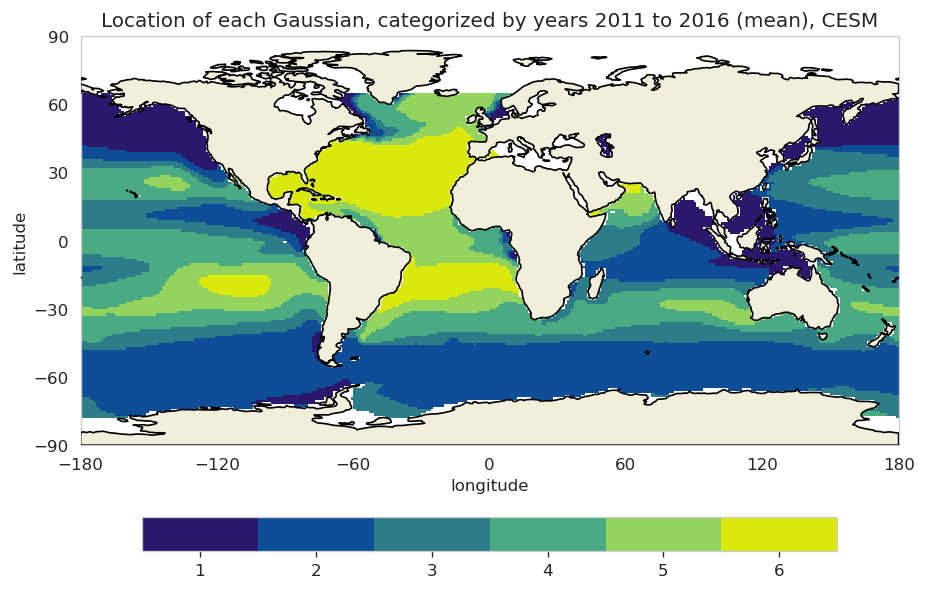

In [19]:
from clustering_tools import clusters
%load_ext autoreload
%autoreload 2
#y,a2=clusters(gm,regrid_iap[0:3].mean('time'),'Location of each Gaussian, categorized by years 1975-1978 (mean), IAP',n)
y,a2=clusters(gm,salt_avg_2006to2055[5*12:10*12,:,:].mean('time'),'Location of each Gaussian, categorized by years 2011 to 2016 (mean), CESM',n,matching_paper=1) #put on the last parameter if want colours to match the line plots of salinity

Now that we have the clusters, we find the trend in the salinity in each of these regions over time. First we define a function which allows us to take an area weighted mean and then apply this to each of the clusters

In [20]:
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

def area_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

In [21]:
s=(salt_avg_2006to2055[5*12:10*12,:,:].mean('time')).where(salt_avg_2006to2055.latitude<65)

x=np.linspace(31,38,10000)
#we have a 50 year time series, we want to find the mean salt at each region defined by the first year at each of these years
salt_cesm=np.empty([45,n])
temp_cesm=np.empty([45,n])
for j in range(0,45):
    s_new=(salt_avg_2006to2055[(j+5)*12:(j+6)*12,:,:].mean('time')).where(salt_avg_2006to2055.latitude<65)
    t_new=(temp_avg_2006to2055[(j+5)*12:(j+6)*12,:,:].mean('time')).where(temp_avg_2006to2055.latitude<65)
    for i in range(0,n):
        salt_cesm[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_cesm[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)
        
#DEFINE THE AREA OF EACH CLUSTER
ones_grid=salt_avg_2006to2055[0,:,:].where(salt_avg_2006to2055[0,:,:]==1, other=1)
area_cluster=np.empty(6)
for i in range(0,n):
    area_cluster[i]=area_disjoint(area,i,s,ones_grid,x,a2)

Plot the timeseries of mean salinity in each cluster over time

Text(0.5, 1.0, 'Change in salinity in each region, CESM ensemble mean')

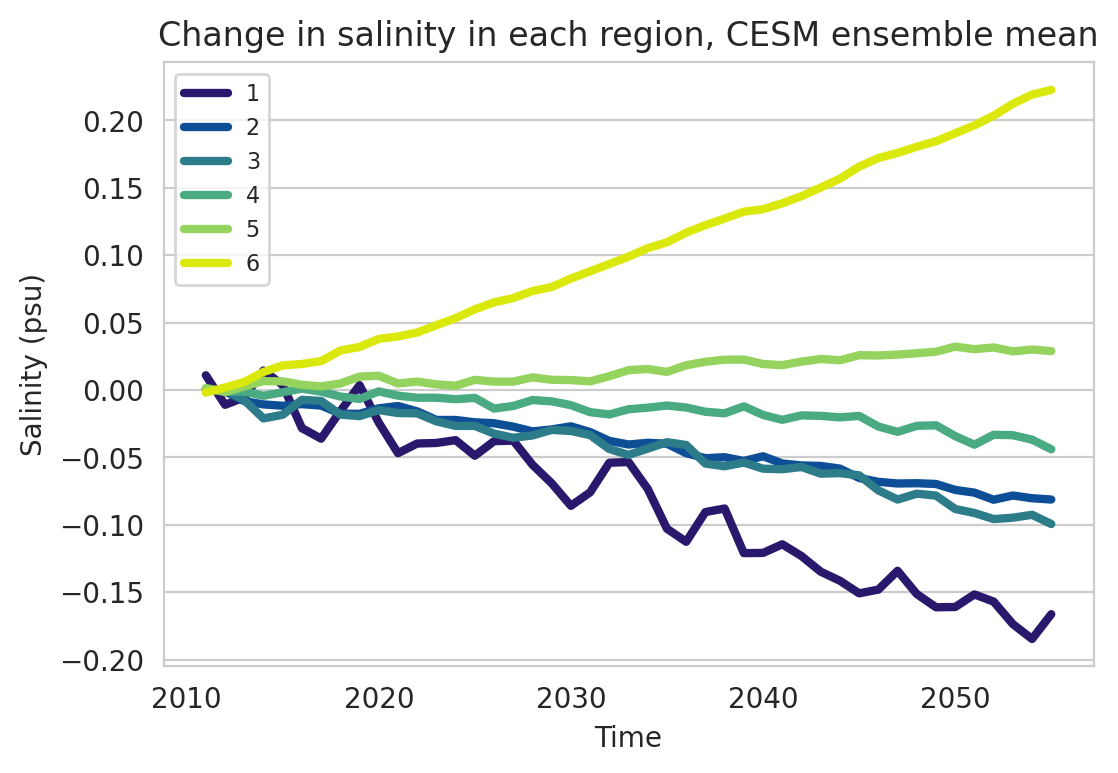

In [22]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
change_cesm=salt_cesm[:,:]-np.mean(salt_cesm[0:2,:],0)
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(2011,2055,45),change_cesm[0:45],linewidth=3)
plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, CESM ensemble mean')

Text(0.5, 1.0, 'Change in temperature in each region, CESM ensemble mean')

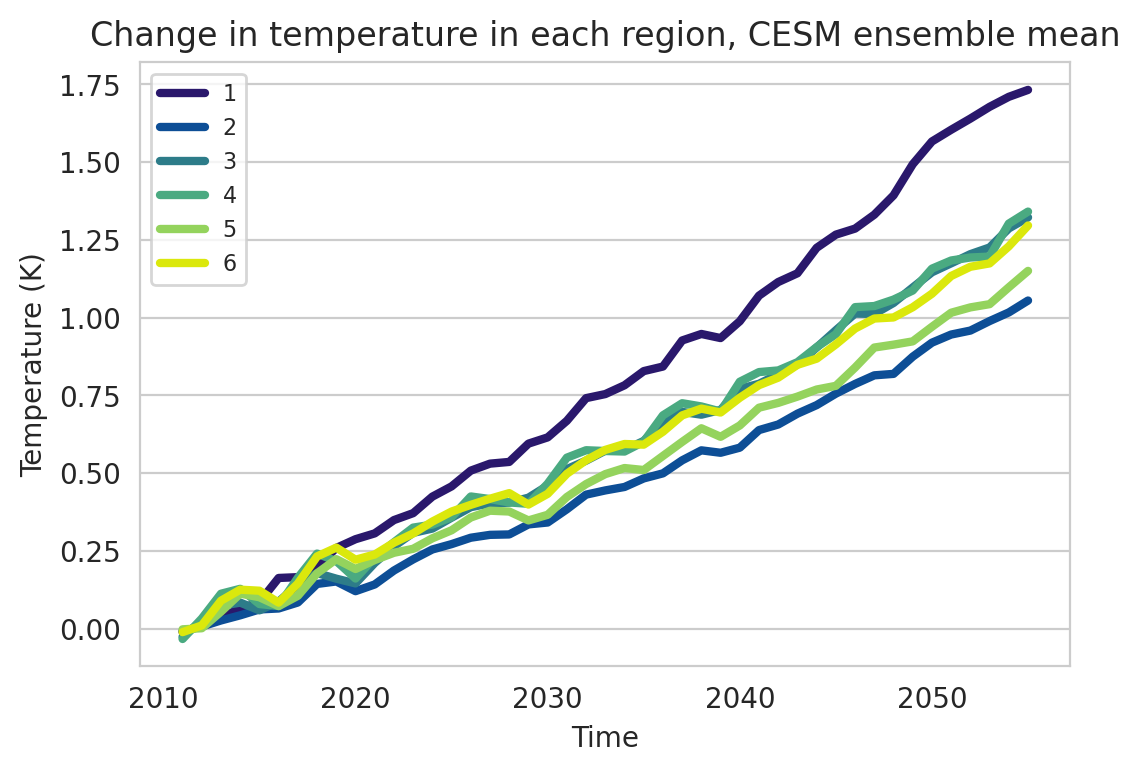

In [23]:
change_temp_cesm=temp_cesm[:,:]-np.mean(temp_cesm[0:2,:],0)

import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(2011,2055,45),change_temp_cesm[0:45],linewidth=3)
plt.legend(['1','2','3','4','5','6','7'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region, CESM ensemble mean')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


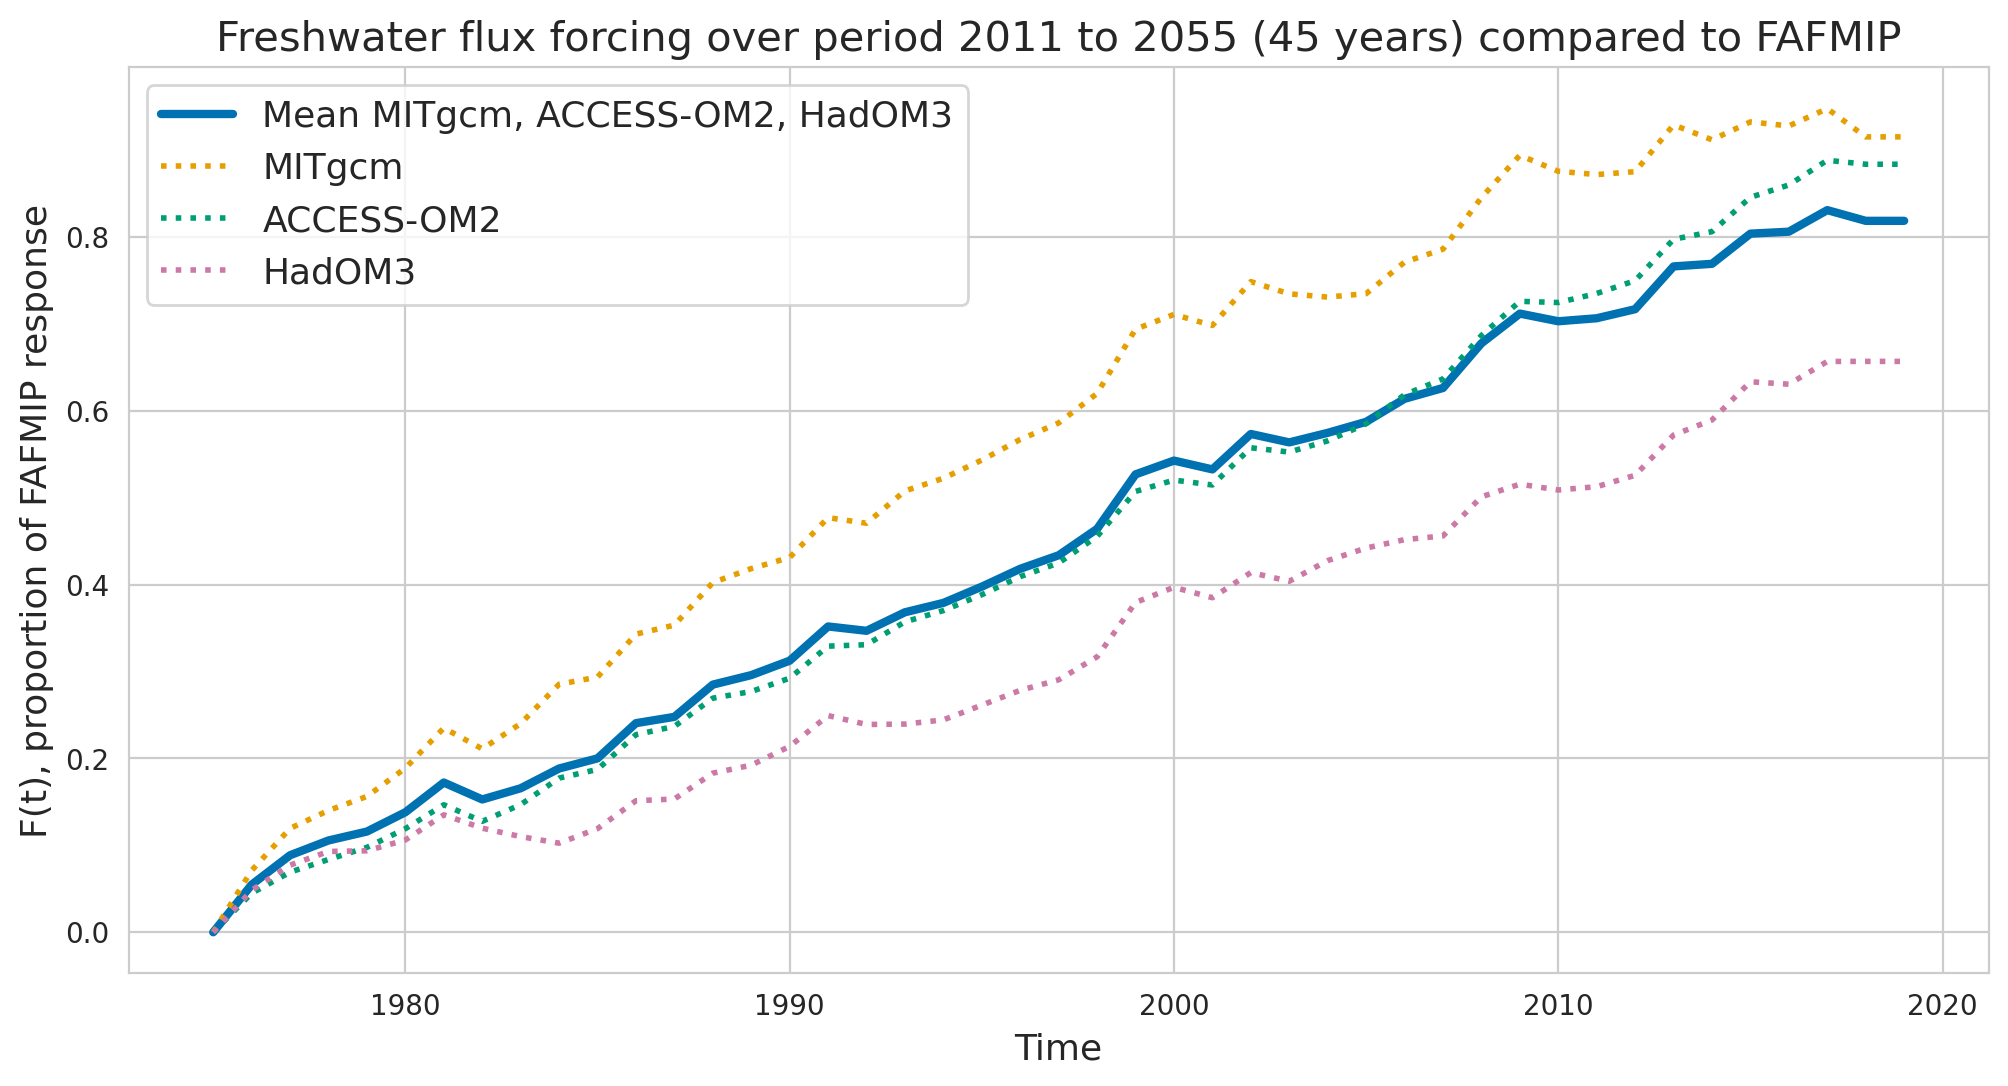

In [25]:
from linear_response_tools import linear_response_single
%load_ext autoreload
%autoreload 2

change_water,change_heat,df3_mean=linear_response_single(change_cesm,change_temp_cesm,a2,salt_avg_2006to2055[4*12:50*12],n,weighted=1,area_cluster=area_cluster,title='Freshwater flux forcing over period 2011 to 2055 (45 years) compared to FAFMIP',output_everything=1) #this is area weighted

In [26]:
change_water

0.7424452150036277

In [28]:
p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,0], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)
change2=np.empty([3000])

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 3000

y_star_cb \
    = circular_block_bootstrap(df3_mean[0:45,0]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    change2[i]=(bootstrap[i][40:45].mean()-bootstrap[i][0:5].mean())

print(change2.mean())
print(change2.std())

0.7547358863482041
0.01375269100109311


In [29]:
#Performing block bootstrapping to get the mean and error bars. Using the last 5 years minus first 5 years metric here.

p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,0], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)
change2=np.empty([3000])
individual_variance=np.empty([3000]) #this saves the individual variance of each new linear trend so that we can account for that in the error bars if we want

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 3000

y_star_cb \
    = circular_block_bootstrap(df3_mean[0:45,0]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=bootstrap[i], alternative='two-sided')
    change2[i]=(p.slope*np.linspace(0,44,45))[-1]
    individual_variance[i]=(p.stderr*45)**2


print(change2.mean()) #mean trend
print(change2.std()) #error bars without accounting for the variance of each newly fitted trend
print(np.sqrt((individual_variance+change2**2).mean()-(change2.mean())**2)) #error bars accounting for spread of new trends and the variance of each newly fitted trend 

0.8302777180685829
0.011386624588972735
0.014859168351854515


In [30]:
0.7543567802706971*(50/45)
0.01375269100109311*(50/45)

0.015280767778992344

0.3661